# Projet AT&T Spam Detector : Determiner si le SMS est un spam ou non

# LIBs

In [70]:
import numpy as np
import pandas as pd

#Import pour NLP
import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS

#TensorFlow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
import tensorflow_hub as hub

#Splitting
from sklearn.model_selection import train_test_split

#Scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, accuracy_score

#Graphes
import matplotlib.pyplot as plt



In [50]:
#utils 

def evaluate_model(desc, model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = { 'description' : desc,
						'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict

# Préparation des Datas

In [2]:
#Récupération du DataSet
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",encoding = "ISO-8859-1")

In [3]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
dataset.shape

(5572, 5)

Si on explore les DATA les colonnes Unnamed ne sont pas toutes vides.

Si on étudie par exemple la ligne 281 : 
ham,\Wen u miss someone, the person is definitely special for u..... But if the person is so special, why to miss them," just Keep-in-touch\"" gdeve.."""
-> On s'apercoit que c'est uniquement des virgules d'une même phrase, on va donc concaténer toutes les colonnes

On vérifie avec la ligne 95 
spam,"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML", PO Box 5249," MK17 92H. 450Ppw 16""",
les données ne sont pas très importantes

On vérifie encore avec ligne 4668
ham,"When I was born, GOD said, \Oh No! Another IDIOT\"". When you were born", GOD said," \""OH No! COMPETITION\"". Who knew"," one day these two will become FREINDS FOREVER!"""
=> Même conclusion on peut tout coller 

In [5]:
#On renseigne les NAN avec des chaines vides
dataset = dataset.fillna('')
#Concatenation des colonnes
dataset['content'] = dataset.iloc[:,1] + dataset.iloc[:,2] + dataset.iloc[:,3] + dataset.iloc[:,4]
#Suppression des colonnes 
dataset.drop(columns=['v2','Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True,axis=1)
#rename de la colonne
dataset.rename(columns={'v1':'target'},inplace=True)

In [6]:
dataset.head()

,target,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#Quelquechose qui joue beaucoup dans le spamming sont les caractères spéciaux, les mails contiennent toujours bcp plus de caractère bizarres
#Voyons si ca se vérifie sur notre dataset

In [9]:
#Fonction de comptage des caractères non alphanum
def compte(chaine):
    count = 0
    for caractere in chaine:
        if not caractere.isalnum():
            count += 1
    return count

In [10]:
dataset["nb_car_non_alpha"] = dataset["content"].apply(lambda x: compte(x))

In [11]:
dataset.groupby(['target']).mean()

/var/folders/gk/g_6gw4153wgc0_gxbmhvzmc40000gn/T/ipykernel_75714/802923674.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset.groupby(['target']).mean()


,nb_car_non_alpha
target,
ham,17.500518
spam,29.132530


Conclusion : Il semblerait qu'il y ai deux fois plus de caractères non alphanum dans les spams.
Nous allons donc doubler nos essais pour voir la différence

# Model WordEmbedding

Application des techniques de NLP, pour cleaner les data, les lemmanizer puis, appliquer du DEEP learnig de classification

In [ ]:
#Utilisation de Spacy avec le dictionnaire des mots anglais complet
#!python -m spacy download en_core_web_lg -q

In [8]:
nlp = en_core_web_lg.load()

In [12]:
#Ajout de colonne en supprimant les caractères speciaux
#remove all non alphanumeric characters except whitespaces
dataset["content_clean"] = dataset["content"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch == "'"))
#dataset["content_clean"] = dataset["content"]
# remove double spaces and spaces at the beginning and end of strings
dataset["content_clean"] = dataset["content_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
dataset["content_clean"] = dataset["content_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [18]:
#Ajout de colonne en conservant les caractères speciaux
dataset["content_clean_all_car"] = dataset["content"]
# remove double spaces and spaces at the beginning and end of strings
dataset["content_clean_all_car"] = dataset["content_clean_all_car"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
dataset["content_clean_all_car"] = dataset["content_clean_all_car"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [20]:
dataset.head()

,target,content,nb_car_non_alpha,content_clean,content_clean_all_car
0,ham,"Go until jurong point, crazy.. Available only ...",28,jurong point crazy available bugis n great wor...,"jurong point , crazy .. available bugis n grea..."
1,ham,Ok lar... Joking wif u oni...,11,ok lar joke wif u oni,ok lar ... joke wif u oni ...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,33,free entry 2 wkly comp win fa cup final tkts 2...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,16,u dun early hor u c,u dun early hor ... u c ...
4,ham,"Nah I don't think he goes to usf, he lives aro...",14,nah think usf live,"nah think usf , live"


In [23]:
#Instance de la classe tokenizer de TF
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=100)
tokenizer_all_car = tf.keras.preprocessing.text.Tokenizer(num_words=100)

In [24]:
#Comptage des mots de nos documents
tokenizer.fit_on_texts(dataset['content_clean']) 
tokenizer_all_car.fit_on_texts(dataset['content_clean_all_car']) 

In [25]:
dataset["content_seq"] = tokenizer.texts_to_sequences(dataset['content_clean'])
dataset["content_seq_all_car"] = tokenizer_all_car.texts_to_sequences(dataset['content_clean_all_car'])

In [26]:
#Verification que nous n'avons pas de liste vides
dataset["content_seq_len"] = dataset["content_seq"].apply(lambda x: len(x))
data_clean = dataset[dataset["content_seq_len"]!=0]

dataset["content_seq_len_all_car"] = dataset["content_seq_all_car"].apply(lambda x: len(x))
data_clean_all_car = dataset[dataset["content_seq_all_car"]!=0]

In [28]:
data_clean.shape

(4649, 8)

In [29]:
data_clean_all_car.shape

(5572, 9)

On constate que l'on a bien une différence de lignes (pour les colonnes c'est normal c'est la construction du code)

In [30]:
data_clean.head()

,target,content,nb_car_non_alpha,content_clean,content_clean_all_car,content_seq,content_seq_all_car,content_seq_len
0,ham,"Go until jurong point, crazy.. Available only ...",28,jurong point crazy available bugis n great wor...,"jurong point , crazy .. available bugis n grea...","[31, 49, 77, 62]","[31, 55, 77, 67]",4
1,ham,Ok lar... Joking wif u oni...,11,ok lar joke wif u oni,ok lar ... joke wif u oni ...,"[8, 1]","[8, 1]",2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,33,free entry 2 wkly comp win fa cup final tkts 2...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 2, 29, 17, 21]","[11, 2, 30, 18, 22, 89, 47]",5
3,ham,U dun say so early hor... U c already then say...,16,u dun early hor u c,u dun early hor ... u c ...,"[1, 1, 80]","[1, 1, 47]",3
4,ham,"Nah I don't think he goes to usf, he lives aro...",14,nah think usf live,"nah think usf , live",[19],[20],1


In [31]:
#Suppression des colonnes 
data_clean.drop(columns=['nb_car_non_alpha','content_clean_all_car','content_seq_all_car'],inplace=True,axis=1)

/var/folders/gk/g_6gw4153wgc0_gxbmhvzmc40000gn/T/ipykernel_75714/1788297561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.drop(columns=['nb_car_non_alpha','content_clean_all_car','content_seq_all_car'],inplace=True,axis=1)


In [32]:
#Suppression des colonnes 
data_clean_all_car.drop(columns=['nb_car_non_alpha','content_clean','content_seq','content_seq_len'],inplace=True,axis=1)
#rename de la colonne
data_clean_all_car.rename(columns={'content_clean_all_car':'content_clean','content_seq_all_car':'content_seq','content_seq_len_all_car':'content_seq_len'},inplace=True)

In [34]:
data_clean_all_car.head()

,target,content,content_clean,content_seq,content_seq_len
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point , crazy .. available bugis n grea...","[31, 55, 77, 67]",4
1,ham,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...,"[8, 1]",2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 2, 30, 18, 22, 89, 47]",7
3,ham,U dun say so early hor... U c already then say...,u dun early hor ... u c ...,"[1, 1, 47]",3
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah think usf , live",[20],1


In [53]:
#Padding des sequences encodée
s_padded = tf.keras.preprocessing.sequence.pad_sequences(data_clean['content_seq'], padding="post")
s_padded_all_car = tf.keras.preprocessing.sequence.pad_sequences(data_clean_all_car['content_seq'], padding="post")

In [36]:
#Création target format numérique 
data_clean['num_target'] = 0
data_clean.loc[data_clean['target'] == 'spam','num_target'] = 1
data_clean_all_car['num_target'] = 0
data_clean_all_car.loc[data_clean_all_car['target'] == 'spam','num_target'] = 1

/var/folders/gk/g_6gw4153wgc0_gxbmhvzmc40000gn/T/ipykernel_75714/4032631969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['num_target'] = 0


In [38]:
data_clean_all_car.head()

,target,content,content_clean,content_seq,content_seq_len,num_target
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point , crazy .. available bugis n grea...","[31, 55, 77, 67]",4,0
1,ham,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...,"[8, 1]",2,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 2, 30, 18, 22, 89, 47]",7,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor ... u c ...,"[1, 1, 47]",3,0
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah think usf , live",[20],1,0


## Test sans les caractères alphanum

In [40]:
#Séparation en train, test et validation set
train_set,val_set,label_train_set,label_val_set = train_test_split(s_padded,data_clean['num_target'],test_size=0.1,stratify=data_clean['num_target'])
train_set,test_set,label_train_set,label_test_set = train_test_split(train_set,label_train_set,test_size=0.2,stratify=label_train_set)

# Création des tenseurs 
train_ds = tf.data.Dataset.from_tensor_slices((train_set,label_train_set))
test_ds = tf.data.Dataset.from_tensor_slices((test_set,label_test_set))
val_ds = tf.data.Dataset.from_tensor_slices((val_set,label_val_set))

#Mélange des data et création de batch en 32
train_ds = train_ds.shuffle(len(train_ds)).batch(32)
test_ds = test_ds.batch(32)

sms_text, lab = next(iter(train_ds))

#Création du modèle
embedding_dim=16 # the dimensionality of the representation space
vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding",input_shape=[sms_text.shape[1],]), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  #Dense(32, activation='relu'), # a dense layer
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

model.summary()

2023-05-16 15:19:10.253464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 15:19:10.253496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 16)            1616      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,905
Trainable params: 1,905
Non-trainable params: 0
_________________________________________________________________


In [41]:
#On compile le modele (legacy utilisé car mac M1)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [42]:
#Entrainement 
model.fit(train_ds,
          epochs=50, 
          validation_data=test_ds)

Epoch 1/50


2023-05-16 15:20:07.853564: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-16 15:20:07.855067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 0.5967 - binary_accuracy: 0.8464

2023-05-16 15:20:12.384800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 5s 20ms/step - loss: 0.5967 - binary_accuracy: 0.8464 - val_loss: 0.4769 - val_binary_accuracy: 0.8471
Epoch 2/50
105/105 [==============================] - 1s 12ms/step - loss: 0.4203 - binary_accuracy: 0.8464 - val_loss: 0.3992 - val_binary_accuracy: 0.8471
Epoch 3/50
105/105 [==============================] - 1s 12ms/step - loss: 0.3947 - binary_accuracy: 0.8464 - val_loss: 0.3857 - val_binary_accuracy: 0.8471
Epoch 4/50
105/105 [==============================] - 1s 12ms/step - loss: 0.3796 - binary_accuracy: 0.8464 - val_loss: 0.3684 - val_binary_accuracy: 0.8471
Epoch 5/50
105/105 [==============================] - 1s 12ms/step - loss: 0.3590 - binary_accuracy: 0.8464 - val_loss: 0.3416 - val_binary_accuracy: 0.8471
Epoch 6/50
105/105 [==============================] - 1s 12ms/step - loss: 0.3165 - binary_accuracy: 0.8551 - val_loss: 0.2805 - val_binary_accuracy: 0.8769
Epoch 7/50
105/105 [==============================] - 1s 11ms/step - 

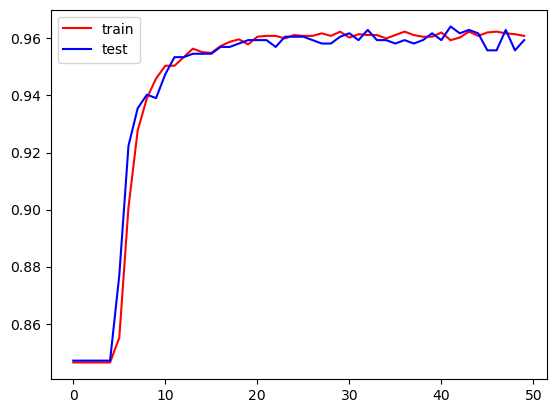

In [43]:
#Trace la courbe d'accuracy
plt.plot(model.history.history["binary_accuracy"], c="r", label="train")
plt.plot(model.history.history["val_binary_accuracy"], c="b", label="test")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Le model converge assez vite, 15 epochs auraient suffit 

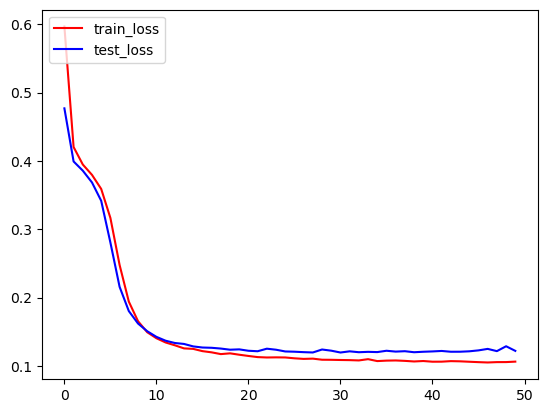

In [44]:
# Trace la loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#même constat

In [51]:
evaluate_model('WordEMB sans alphanum',model, test_set, label_test_set)

27/27 [==============================] - 0s 3ms/step


2023-05-16 15:29:05.949382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'description': 'WordEMB sans alphanum',
 'accuracy': 0.959378733572282,
 'precision': 0.9607843137254902,
 'recall': 0.765625,
 'f1-score': 0.8521739130434782}

## Test avec les alphanums

In [60]:
#Séparation en train, test et validation set
train_set,val_set,label_train_set,label_val_set = train_test_split(s_padded_all_car,data_clean_all_car['num_target'],test_size=0.1,stratify=data_clean_all_car['num_target'])
train_set,test_set,label_train_set,label_test_set = train_test_split(train_set,label_train_set,test_size=0.2,stratify=label_train_set)

# Création des tenseurs 
train_ds = tf.data.Dataset.from_tensor_slices((train_set,label_train_set))
test_ds = tf.data.Dataset.from_tensor_slices((test_set,label_test_set))
val_ds = tf.data.Dataset.from_tensor_slices((val_set,label_val_set))

#Mélange des data et création de batch en 32
train_ds = train_ds.shuffle(len(train_ds)).batch(32)
test_ds = test_ds.batch(32)

sms_text, lab = next(iter(train_ds))

#Création du modèle
embedding_dim=16 # the dimensionality of the representation space
vocab_size = tokenizer_all_car.num_words # the number of words in the vocabulary
model_all_car = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding",input_shape=[sms_text.shape[1],]), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  #Dense(32, activation='relu'), # a dense layer
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

model_all_car.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 16)            1616      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,905
Trainable params: 1,905
Non-trainable params: 0
_________________________________________________________________


In [61]:
#On compile le modele (legacy utilisé car mac M1)
model_all_car.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [62]:
#Entrainement 
model_all_car.fit(train_ds,
          epochs=50, 
          validation_data=test_ds)

Epoch 1/50


2023-05-16 15:33:32.677273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - ETA: 0s - loss: 0.5529 - binary_accuracy: 0.8651

2023-05-16 15:33:35.018833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 3s 18ms/step - loss: 0.5529 - binary_accuracy: 0.8651 - val_loss: 0.4084 - val_binary_accuracy: 0.8664
Epoch 2/50
126/126 [==============================] - 2s 12ms/step - loss: 0.3790 - binary_accuracy: 0.8659 - val_loss: 0.3672 - val_binary_accuracy: 0.8664
Epoch 3/50
126/126 [==============================] - 1s 11ms/step - loss: 0.3631 - binary_accuracy: 0.8659 - val_loss: 0.3538 - val_binary_accuracy: 0.8664
Epoch 4/50
126/126 [==============================] - 2s 12ms/step - loss: 0.3436 - binary_accuracy: 0.8659 - val_loss: 0.3263 - val_binary_accuracy: 0.8664
Epoch 5/50
126/126 [==============================] - 2s 12ms/step - loss: 0.3053 - binary_accuracy: 0.8696 - val_loss: 0.2778 - val_binary_accuracy: 0.8824
Epoch 6/50
126/126 [==============================] - 2s 13ms/step - loss: 0.2510 - binary_accuracy: 0.8920 - val_loss: 0.2254 - val_binary_accuracy: 0.9143
Epoch 7/50
126/126 [==============================] - 2s 12ms/step - 

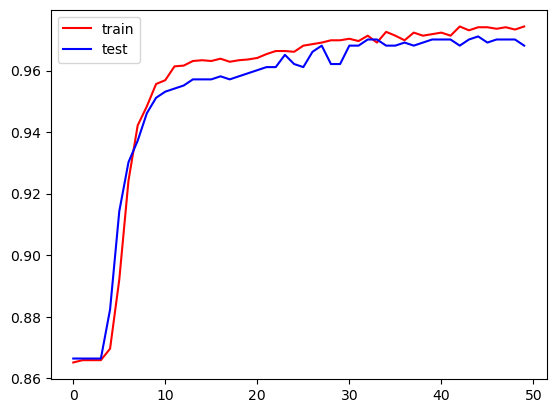

In [63]:
#Trace la courbe d'accuracy
plt.plot(model_all_car.history.history["binary_accuracy"], c="r", label="train")
plt.plot(model_all_car.history.history["val_binary_accuracy"], c="b", label="test")
plt.legend(loc="upper left")
plt.show()

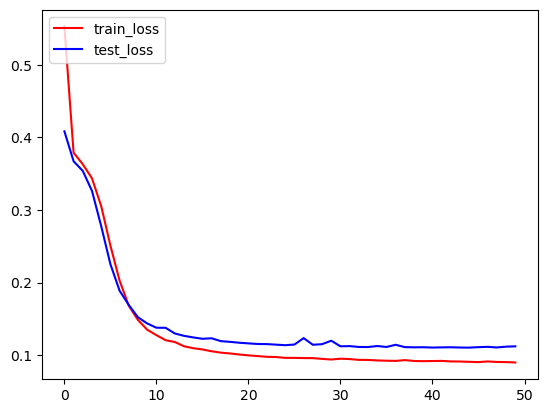

In [64]:
# Trace la loss
plt.plot(model_all_car.history.history["loss"], c="r", label="train_loss")
plt.plot(model_all_car.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [65]:
evaluate_model('WordEMB avec alphanum',model_all_car, test_set, label_test_set)

32/32 [==============================] - 0s 3ms/step


2023-05-16 15:36:43.080625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'description': 'WordEMB avec alphanum',
 'accuracy': 0.9680957128614157,
 'precision': 0.9396551724137931,
 'recall': 0.8134328358208955,
 'f1-score': 0.872}

In [ ]:
#{'description': 'WordEMB sans alphanum',
# 'accuracy': 0.959378733572282,
# 'precision': 0.9607843137254902,
# 'recall': 0.765625,
# 'f1-score': 0.8521739130434782}

Le model semble être un peu meilleurs sauf en recall. Etant donné le mode de calcul (TP/(TP+FN)), on peut facilement déduire qu'il y a une différence de classement de certain spam, regardons les confusions matrix des deux modèles

32/32 [==============================] - 0s 3ms/step


2023-05-16 15:40:22.971338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


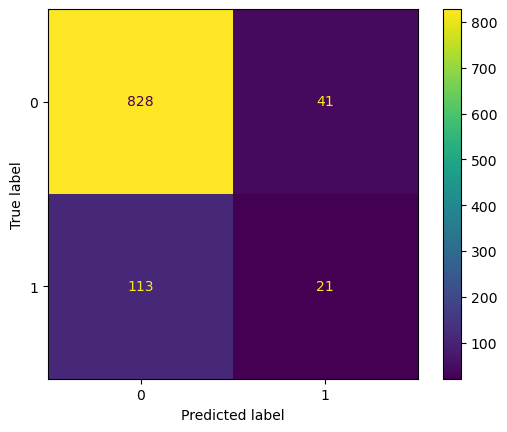

In [66]:
#disp = ConfusionMatrixDisplay
cm = confusion_matrix(label_test_set, np.round(model.predict(test_set)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

32/32 [==============================] - 0s 2ms/step


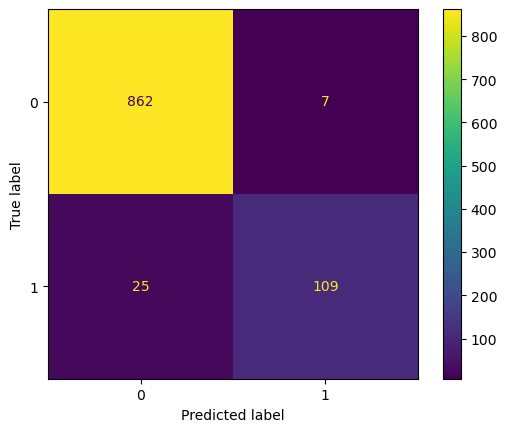

In [68]:
#disp = ConfusionMatrixDisplay
cm_all_car = confusion_matrix(label_test_set, np.round(model_all_car.predict(test_set)))
disp_all_car = ConfusionMatrixDisplay(confusion_matrix=cm_all_car)
disp_all_car.plot()
plt.show()

en comparant les deux modèles c'est sans equivoque. Nous avons 32 erreurs de classement sur 1000 lignes, tout à l'heure nous étions à 154. 
Le second model sera beaucoup plus adapté à ce que nous souhaitons car l'utilisateur recevra 862 messages qui ne sont pas des spams 
109 iront directement à la poubelle et l'utilisateurs aura 32 action à faire pour continuer à faire apprendre le modèle dans le cas ou nous serions en reinforcement learning. 
Nous avons quand même un bon score.

# Transfer Learning Universal Sentence Encoder

In [83]:
#Creation d'un model sequentiel
model_USE = tf.keras.Sequential()

#Transfert Learning 
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')

model_USE.add(use_layer)
model_USE.add(tf.keras.layers.Dense(16, activation='relu')), # a dense layer
model_USE.add(tf.keras.layers.Dense(1, activation="sigmoid")) # the prediction layer

#On compile le modele (legacy utilisé car mac M1)
model_USE.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

model_USE.summary()


2023-05-16 16:04:30.453573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 16)                8208      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 8,225
Non-trainable params: 256,797,824
_________________________________________________________________


On voit le transfert learning avec 256,797,824 non entrainable 


In [75]:
#Le modele USE n'a pas besoin de token, nous pouvons lui envoyer les phrases directement
#Séparation en train, test et validation set
train_set,val_set,label_train_set,label_val_set = train_test_split(data_clean['content_clean'],data_clean['num_target'],test_size=0.1,stratify=data_clean['num_target'])
train_set,test_set,label_train_set,label_test_set = train_test_split(train_set,label_train_set,test_size=0.2,stratify=label_train_set)


In [79]:
label_val_set.shape

(465,)

In [81]:
train_set

4862    bored housewife chat n date 08717507711 btnati...
3240                 ok send u da late version da project
3291                          dear good morning feel dear
2590    lol member aunt flow visit 6 month cause devel...
2611    knock knock txt 80082 enter r weekly draw 4 å2...
                              ...                        
3379                                   finish miss plenty
3993               love cuddle want hold strong arm right
4093                                                 miss
4980                                           okay sorry
547                                        sorry long omw
Name: content_clean, Length: 3347, dtype: object

In [84]:
#Entrainement 
model_USE.fit(train_set,label_train_set,
          epochs=50, 
          validation_data=(val_set,label_val_set))

Epoch 1/50


2023-05-16 16:04:38.921536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 0.5758 - binary_accuracy: 0.8303

2023-05-16 16:04:45.390346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 9s 72ms/step - loss: 0.5758 - binary_accuracy: 0.8303 - val_loss: 0.4175 - val_binary_accuracy: 0.9484
Epoch 2/50
105/105 [==============================] - 5s 51ms/step - loss: 0.2945 - binary_accuracy: 0.9579 - val_loss: 0.2095 - val_binary_accuracy: 0.9656
Epoch 3/50
105/105 [==============================] - 5s 48ms/step - loss: 0.1636 - binary_accuracy: 0.9668 - val_loss: 0.1431 - val_binary_accuracy: 0.9656
Epoch 4/50
105/105 [==============================] - 5s 46ms/step - loss: 0.1177 - binary_accuracy: 0.9695 - val_loss: 0.1185 - val_binary_accuracy: 0.9699
Epoch 5/50
105/105 [==============================] - 5s 45ms/step - loss: 0.0962 - binary_accuracy: 0.9728 - val_loss: 0.1063 - val_binary_accuracy: 0.9656
Epoch 6/50
105/105 [==============================] - 5s 44ms/step - loss: 0.0833 - binary_accuracy: 0.9749 - val_loss: 0.0978 - val_binary_accuracy: 0.9677
Epoch 7/50
105/105 [==============================] - 5s 43ms/step - 

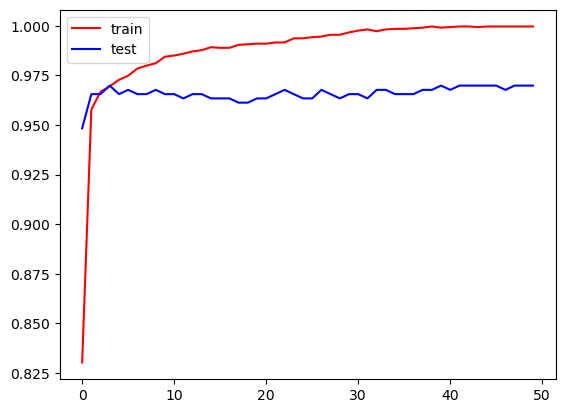

In [85]:
#Trace la courbe d'accuracy
plt.plot(model_USE.history.history["binary_accuracy"], c="r", label="train")
plt.plot(model_USE.history.history["val_binary_accuracy"], c="b", label="test")
plt.legend(loc="upper left")
plt.show()

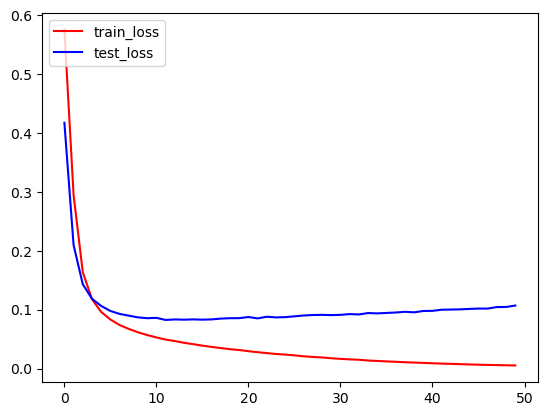

In [86]:
# Trace la loss
plt.plot(model_USE.history.history["loss"], c="r", label="train_loss")
plt.plot(model_USE.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [87]:
evaluate_model('USE sans alphanum',model_USE, test_set, label_test_set)

2023-05-16 16:12:20.819175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 6s 177ms/step


{'description': 'USE sans alphanum',
 'accuracy': 0.982078853046595,
 'precision': 0.9312977099236641,
 'recall': 0.953125,
 'f1-score': 0.9420849420849421}

In [88]:
#Creation d'un model sequentiel
model_USE_all_car = tf.keras.Sequential()

#Transfert Learning 
use_layer_all_car = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')

model_USE_all_car.add(use_layer_all_car)
model_USE_all_car.add(tf.keras.layers.Dense(16, activation='relu')), # a dense layer
model_USE_all_car.add(tf.keras.layers.Dense(1, activation="sigmoid")) # the prediction layer

#On compile le modele (legacy utilisé car mac M1)
model_USE_all_car.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

model_USE_all_car.summary()

2023-05-16 16:13:22.812661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 16)                8208      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 8,225
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
#Le modele USE n'a pas besoin de token, nous pouvons lui envoyer les phrases directement
#Séparation en train, test et validation set
train_set,val_set,label_train_set,label_val_set = train_test_split(data_clean_all_car['content_clean'],data_clean_all_car['num_target'],test_size=0.1,stratify=data_clean_all_car['num_target'])
train_set,test_set,label_train_set,label_test_set = train_test_split(train_set,label_train_set,test_size=0.2,stratify=label_train_set)


In [90]:
#Entrainement 
model_USE_all_car.fit(train_set,label_train_set,
          epochs=50, 
          validation_data=(val_set,label_val_set))

Epoch 1/50


2023-05-16 16:14:02.333779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - ETA: 0s - loss: 0.3976 - binary_accuracy: 0.8816

2023-05-16 16:14:18.012185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 21s 155ms/step - loss: 0.3976 - binary_accuracy: 0.8816 - val_loss: 0.2114 - val_binary_accuracy: 0.9516
Epoch 2/50
126/126 [==============================] - 11s 88ms/step - loss: 0.1519 - binary_accuracy: 0.9668 - val_loss: 0.1196 - val_binary_accuracy: 0.9731
Epoch 3/50
126/126 [==============================] - 10s 80ms/step - loss: 0.1001 - binary_accuracy: 0.9728 - val_loss: 0.0962 - val_binary_accuracy: 0.9695
Epoch 4/50
126/126 [==============================] - 9s 75ms/step - loss: 0.0818 - binary_accuracy: 0.9766 - val_loss: 0.0874 - val_binary_accuracy: 0.9713
Epoch 5/50
126/126 [==============================] - 9s 72ms/step - loss: 0.0710 - binary_accuracy: 0.9793 - val_loss: 0.0813 - val_binary_accuracy: 0.9731
Epoch 6/50
126/126 [==============================] - 9s 70ms/step - loss: 0.0636 - binary_accuracy: 0.9796 - val_loss: 0.0793 - val_binary_accuracy: 0.9749
Epoch 7/50
126/126 [==============================] - 9s 69ms/ste

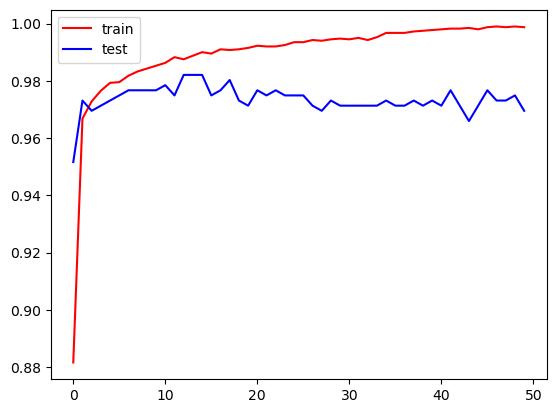

In [91]:
#Trace la courbe d'accuracy
plt.plot(model_USE_all_car.history.history["binary_accuracy"], c="r", label="train")
plt.plot(model_USE_all_car.history.history["val_binary_accuracy"], c="b", label="test")
plt.legend(loc="upper left")
plt.show()

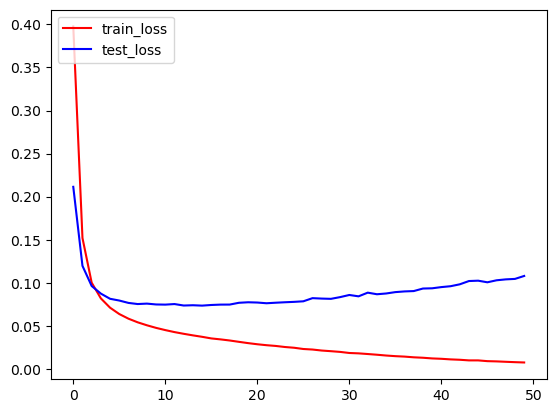

In [92]:
# Trace la loss
plt.plot(model_USE_all_car.history.history["loss"], c="r", label="train_loss")
plt.plot(model_USE_all_car.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [93]:
evaluate_model('USE avec alphanum',model_USE_all_car, test_set, label_test_set)

2023-05-16 16:22:11.827618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 10s 297ms/step


{'description': 'USE avec alphanum',
 'accuracy': 0.9720837487537388,
 'precision': 0.8897058823529411,
 'recall': 0.9029850746268657,
 'f1-score': 0.8962962962962964}

{'description': 'USE sans alphanum',
 'accuracy': 0.982078853046595,
 'precision': 0.9312977099236641,
 'recall': 0.953125,
 'f1-score': 0.9420849420849421}

32/32 [==============================] - 7s 203ms/step


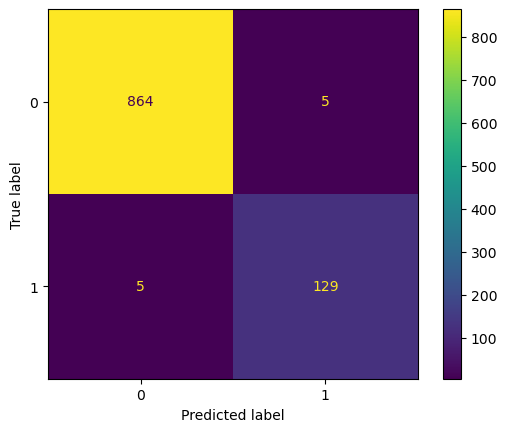

In [94]:
#disp = ConfusionMatrixDisplay
cm = confusion_matrix(label_test_set, np.round(model_USE.predict(test_set)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

32/32 [==============================] - 4s 126ms/step


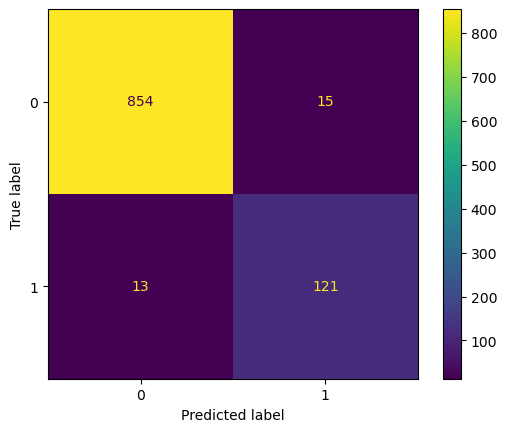

In [95]:
#disp = ConfusionMatrixDisplay
cm_all_car = confusion_matrix(label_test_set, np.round(model_USE_all_car.predict(test_set)))
disp_all_car = ConfusionMatrixDisplay(confusion_matrix=cm_all_car)
disp_all_car.plot()
plt.show()

Analyse du model avec transfert
Nous sommes à 10 mal classé sur 1000 sans les caractère spéciaux 
et 28 avec les caractères spéciaux.
Le modele USE prend en compte le contexte des phrases, sont analyse est donc tout autre, il n'a pas besoin de la ponctuation et autre. Ce qui explique la bonne reussite du modèle sans ponctuation. 
Nous somme tout de meme à 28 avec la ponctuation ce qui est mieux. 

Piste d'amelioration : 
Augmenter le dataset, en effet il est relativement petit par rapport au nombre de parametre du modele USE. 
Ceci explique un overfitting trop important. 

AJouter une couche de drop out permettrait de reduire cet overfiting. 

Verifier aussi la liste des stop word. En effet le spamming, contient un vocabulaire assez récurent. il faudrait s'assurer que certain mot n'ont pas été supprimé à cet etape avec un wordcloud par exemple. 

IL serait aussi interessant d'intégrer la notion du numéro de téléphone ( ou du mail dans le cas de spam mail), car on peut en apprendre beaucoup avec l'adresse email. 

Peut-être récupérer les informations des noms de domaines ou de propriétaire des numéro des sms 

# BERT

J'ai voulu essayé le modèle BERT, mais j'ai rencontré bcp de problème car la librairie tensorflow text n'est pas installable sur mac m1 (pas avec pip en tout cas, il faut recompiler les sources... Etc ..)

Le code est néamoins pret et peu s'executer sur google collab avec un small bert. Le BERT normal dépasse la ram alouée 


In [ ]:
import numpy as np
import pandas as pd

#TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
#PB SUR MAC M1
import tensorflow_text

#Splitting
from sklearn.model_selection import train_test_split

#Scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, accuracy_score

#Graphes
import matplotlib.pyplot as plt

In [ ]:
#Récupération du DataSet
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",encoding = "ISO-8859-1")
#On renseigne les NAN avec des chaines vides
dataset = dataset.fillna('')
#Concatenation des colonnes
dataset['content'] = dataset.iloc[:,1] + dataset.iloc[:,2] + dataset.iloc[:,3] + dataset.iloc[:,4]
#Suppression des colonnes 
dataset.drop(columns=['v2','Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True,axis=1)
#rename de la colonne
dataset.rename(columns={'v1':'target'},inplace=True)
#Création target format numérique 
dataset['num_target'] = 0
dataset.loc[dataset['target'] == 'spam','num_target'] = 1

In [ ]:
#Chargement du model de preprocess BERT
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#A la sortie c'est un dictionnaire avec 3 elements 

#Chargement d'un model BERT SMALL 
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",trainable=False, name="bert")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprossessing = bert_preprocess_model(text_input)
bert_outputs = bert_model(preprossessing)
bert_pooled_outputs = bert_outputs['pooled_output']
dense_layer = tf.keras.layers.Dense(64, activation="relu")(bert_pooled_outputs)
final_outputs = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer)
model_bert = tf.keras.Model(inputs=text_input, outputs=final_outputs)
model_bert.summary()

In [ ]:
#On compile le modele (legacy utilisé car mac M1)
model_bert.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
#Meme découpage que pour les autres models 
train_set,val_set,label_train_set,label_val_set = train_test_split(dataset['content'],dataset['num_target'],test_size=0.1,stratify=dataset['num_target'])
train_set,test_set,label_train_set,label_test_set = train_test_split(train_set,label_train_set,test_size=0.2,stratify=label_train_set)


In [ ]:
#Entrainement 
model_bert.fit(train_set,label_train_set,
          epochs=50, 
          validation_data=(val_set,label_val_set))

In [ ]:
#Trace la courbe d'accuracy
plt.plot(model_bert.history.history["binary_accuracy"], c="r", label="train")
plt.plot(model_bert.history.history["val_binary_accuracy"], c="b", label="test")
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Trace la loss
plt.plot(model_bert.history.history["loss"], c="r", label="train_loss")
plt.plot(model_bert.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#disp = ConfusionMatrixDisplay
cm_all_car = confusion_matrix(label_test_set, np.round(model_bert.predict(test_set)))
disp_all_car = ConfusionMatrixDisplay(confusion_matrix=cm_all_car)
disp_all_car.plot()
plt.show()